# Logistic Regression Exercise

Now it's your turn to implement logistic regression on a new data set. For this purpose we use the Titanic Dataset. It includes personal information of all passengers on the Titanic as well as they survived the sinking of the Titanic or died.

Here’s the **Data Dictionary** of the dataset:

- PassengerID: type should be integers

- Survived: survived or not

- Pclass: class of Travel of every passenger

- Name: the name of the passenger

- Sex: gender

- Age: age of passengers

- SibSp: No. of siblings/spouse aboard

- Parch: No. of parent/child aboard

- Ticket: Ticket number

- Fare: what Prices they paid

- Cabin: cabin number

- Embarked: the port in which a passenger has embarked.

        - C: Cherbourg , S: Southampton , Q: Queenstown


You will find the data in the data folder (it's a zip folder, so you first have to unzip it).


## What you should do:

- conduct a brief EDA to become familiar with the data
- use Logistic Regression to predict if a passenger died or not

## How to do it:

Time is short, so aim for the simplest viable product first:
1. Load the data

2. Separate features and target 

3. Split the data in train and test

3. Get a quick overview of the train data

4. Agree on a classification metric for the task 

5. Create a simple heuristic/educated guess for the classification first. This is called a "baseline model". It is used to compare more complex models later (in this case: logistic regression). You as a data scientist want to prove how much your work/ML could improve the business metric, therefore you need a baseline model for comparison. In some cases you want to improve on an already existing model in your company which would be your baseline model then. In other cases, there are typical baseline models used in the specific field. For other tasks, you have to come up with a simple but meaningful idea, how to classify the data based on your business understanding (EDA). A baseline model should follow Occam’s Razor principle: "A simple model is the best model". 
    - Example of a baseline model: 
    If the task is to classify cats and dogs, a baseline model could be: We classify every animal as cat if its weight < 5 kg, otherwise the animal is classified as a dog. (The value of 5 kg is an educated guess, based on our business understanding/EDA.) 

6. use one or two already numerical features to create a simple first model
    -  did it even beat your base model?

7. Now you can go through the data science lifecycle again and again:
    - clean the data better

    - get more insights with EDA

    - add more features

    - do feature engineering 
    
    and check if your work improves your model further!

8. Stop whenever time is up or you cannot improve your model any further.

This repo a solution to this problem. If you want to compare your final result with the result of this repo solution, choose **25** as random seed and a test size of 30% for your train test split.

## Imports

In [275]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📐 Statistics (optional / analysis support)
# ============================================================
import scipy.stats as stats

# ============================================================
# 🤖 Machine Learning — Data Splitting & Validation
# ============================================================
from sklearn.model_selection import (
    train_test_split
)

# ============================================================
# 🧱 Preprocessing & Pipelines
# ============================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# ============================================================
# ⚖️ Classification Models
# ============================================================
from sklearn.linear_model import LogisticRegression

# ============================================================
# 📏 Evaluation Metrics
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)


# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)



## Model Evaluation Utilities
This section defines reusable evaluation functions used across
all classification models in this notebook.

In [276]:

RANDOM_STATE = 0

def metric_report(y_true, y_pred, y_proba=None, label="model"):
    # Basic metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # ROC-AUC (if probabilities are provided)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    # PR-AUC
    if y_proba is not None:
        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = auc(rec_curve, prec_curve)
    else:
        pr_auc = None

    out = {
        "model": label,
        "accuracy": acc,
        "precision": prec,
        "specificity": spec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }
    return out

def plot_roc_pr(y_true, y_score, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    rocA = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    prA = auc(rec, prec)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={rocA:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(rec, prec, label=f"AP={prA:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} Precision-Recall"); plt.legend()
    plt.show()

def show_confusion(y_true, y_pred, title="Confusion Matrix"):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title); plt.show()

## Model Result Logging

In [277]:
# ====================================
# Classification Log Collector
# ====================================

# No need to import pandas again!

# Safe init

class_log = []

def log_class_result(model_name, acc, prec, spec, rec, f1, roc_auc, pr_auc, feature_count=None):
    class_log.append({
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Specificity": round(spec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3),
        "ROC_AUC": round(roc_auc, 3) if roc_auc is not None else None,
        "PR_AUC": round(pr_auc,3) if pr_auc is not None else None,
        "Feature_Count": int(feature_count) if feature_count is not None else None
    })

## 1. Data Preparation and Preprocessing

### 1.1 Load Raw Data

In [278]:
# Load raw marketing campaign dataset
df = pd.read_csv('Data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [280]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [281]:
print("\n=== DESCRIBE (numeric) ===")
display(df.select_dtypes(include="number").describe().T)


=== DESCRIBE (numeric) ===


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [283]:
# 1) Constant columns (no variance)
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]

print("=== Constant columns (nunique <= 1) ===")
if constant_cols:
    display(pd.DataFrame({
        "column": constant_cols,
        "unique_values": [df[c].unique() for c in constant_cols]
    }))
else:
    print("No constant columns found.")

=== Constant columns (nunique <= 1) ===
No constant columns found.


In [284]:
# (Optional) quick value_counts for common fields if they exist
for c in ["Sex", "Ticket", "Cabin", "Embarked"]:
    if c in df.columns:
        print(f"\n=== VALUE COUNTS: {c} ===")
        display(df[c].value_counts(dropna=False).head(20))


=== VALUE COUNTS: Sex ===


Sex
male      577
female    314
Name: count, dtype: int64


=== VALUE COUNTS: Ticket ===


Ticket
347082          7
CA. 2343        7
1601            7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
LINE            4
PC 17757        4
17421           4
349909          4
113760          4
4133            4
113781          4
W./C. 6608      4
2666            4
19950           4
347077          4
C.A. 31921      3
Name: count, dtype: int64


=== VALUE COUNTS: Cabin ===


Cabin
NaN                687
C23 C25 C27          4
G6                   4
B96 B98              4
C22 C26              3
D                    3
F33                  3
E101                 3
F2                   3
B20                  2
E67                  2
C125                 2
E24                  2
B49                  2
B77                  2
D35                  2
C78                  2
C93                  2
C65                  2
B57 B59 B63 B66      2
Name: count, dtype: int64


=== VALUE COUNTS: Embarked ===


Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

### 1.2 Initial Feature Pruning

In [285]:
# ----------------------------------
# Initial Feature Pruning
# ----------------------------------

cols_to_drop = ["PassengerId", "Name", "Cabin"]

df = df.drop(columns=cols_to_drop)

df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

### 1.3 Train / Test Split
- Stratified split based on the target variable
- All subsequent steps are fitted only on training data


In [286]:
# ----------------------------------
# 1.4 Train / Test Split
# ----------------------------------

# Define target (binary classification)
y = df["Survived"]

# Define feature matrix
X = df.drop(columns=["Survived"])

# Perform stratified train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=25,
    stratify=y
)

# Sanity check
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((623, 8), (268, 8), (623,), (268,))

### 1.4 Missing Value Imputation (Train-only fit)

In [287]:
# -------------------------------
# 1.4 Fit median on TRAIN only
# -------------------------------
age_median = X_train['Age'].median()

X_train['Age'] = X_train['Age'].fillna(age_median)
X_test['Age']  = X_test['Age'].fillna(age_median)

# Check remaining missing values in Age
display(X_train['Age'].isna().sum())
display(X_train['Age'].isna().sum())

0

0

In [288]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 468 to 745
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    623 non-null    int64  
 1   Sex       623 non-null    object 
 2   Age       623 non-null    float64
 3   SibSp     623 non-null    int64  
 4   Parch     623 non-null    int64  
 5   Ticket    623 non-null    object 
 6   Fare      623 non-null    float64
 7   Embarked  622 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 43.8+ KB


### 1.5 Categorical Missing Value Imputation (Train-fitted)

In [289]:
# ----------------------------------
# 1.5 Categorical Missing Value Imputation (Train-Only Fit)
# ----------------------------------

# Compute mode from training data only
embarked_mode = X_train["Embarked"].mode()[0]

# Apply to both train and test
X_train["Embarked"] = X_train["Embarked"].fillna(embarked_mode)
X_test["Embarked"]  = X_test["Embarked"].fillna(embarked_mode)


In [290]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 468 to 745
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    623 non-null    int64  
 1   Sex       623 non-null    object 
 2   Age       623 non-null    float64
 3   SibSp     623 non-null    int64  
 4   Parch     623 non-null    int64  
 5   Ticket    623 non-null    object 
 6   Fare      623 non-null    float64
 7   Embarked  623 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 43.8+ KB


### 1.6 Exploratory Analysis on Training Data

#### 1.6.0 Target Distribution Analysis (Train Set)

In [291]:
# ----------------------------------
# 1.6.0 Target Distribution Analysis (Train Set)
# ----------------------------------

y_train.value_counts()

Survived
0    384
1    239
Name: count, dtype: int64

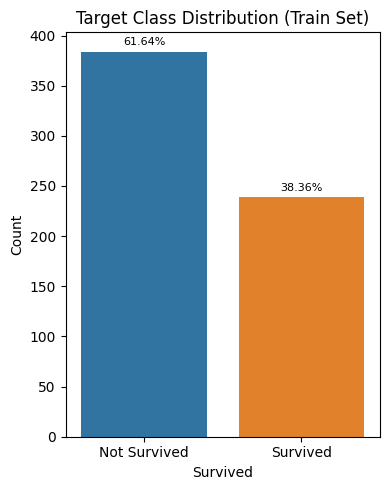

In [293]:
plt.figure(figsize=(4, 5))
ax = sns.countplot(x=y_train)

plt.xticks([0, 1], ["Not Survived", "Survived"])
plt.title("Target Class Distribution (Train Set)")
plt.ylabel("Count")

# -------------------------------
# Add rate labels on top of bars
# -------------------------------
total = len(y_train)

for p in ax.patches:
    count = p.get_height()
    rate = count / total
    ax.annotate(
        f"{rate:.2%}",
        (p.get_x() + p.get_width() / 2., count),
        ha="center",
        va="bottom",
        fontsize=8,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()


#### 1.6.1 Numeric Features vs Target (Train Set)

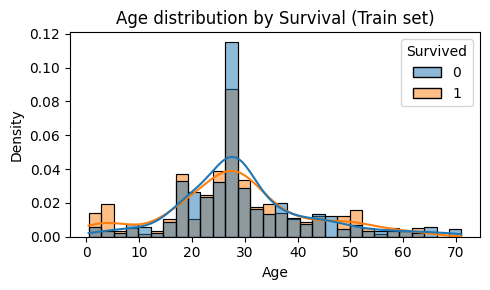

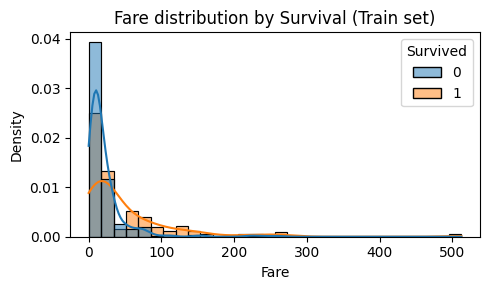

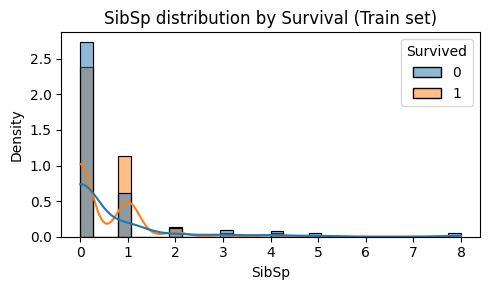

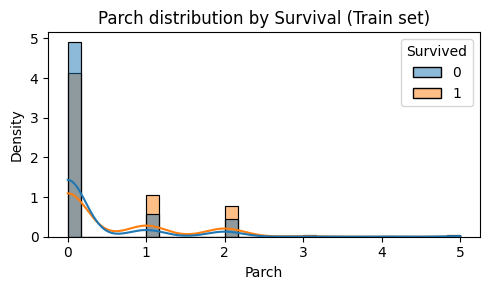

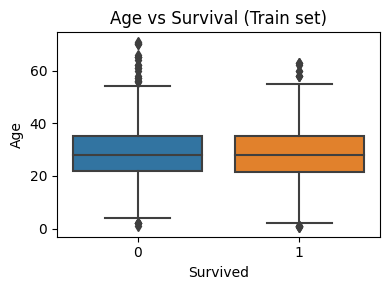

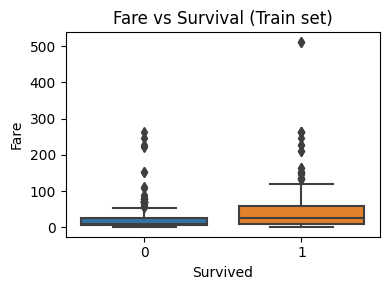

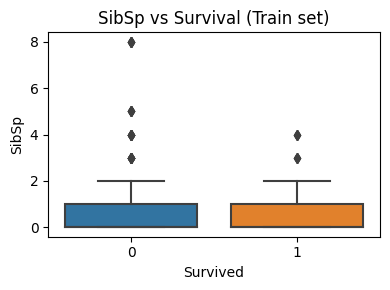

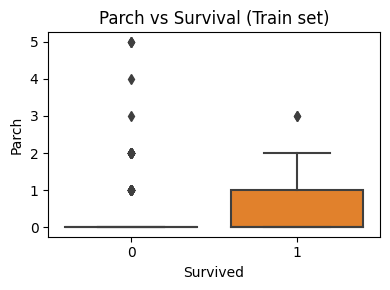

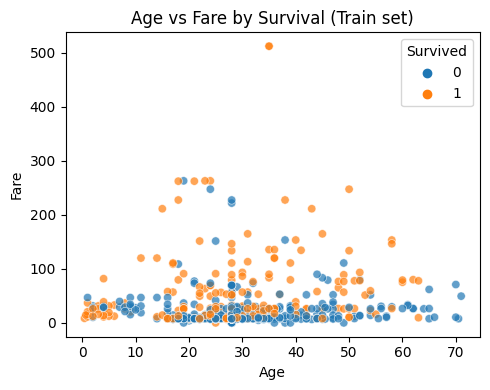

In [294]:
# ----------------------------------
# 1.6.1 Numeric Features vs Survival
# ----------------------------------

# Combine X_train and y_train only for EDA
df_train = X_train.copy()
df_train["Survived"] = y_train.values

numeric_cols = ["Age", "Fare", "SibSp", "Parch"]

# 1️⃣ Distribution plots
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(
        data=df_train,
        x=col,
        hue="Survived",
        bins=30,
        kde=True,
        stat="density",
        common_norm=False
    )
    plt.title(f"{col} distribution by Survival (Train set)")
    plt.tight_layout()
    plt.show()

# 2️⃣ Boxplots
for col in numeric_cols:
    plt.figure(figsize=(4, 3))
    sns.boxplot(
        data=df_train,
        x="Survived",
        y=col
    )
    plt.title(f"{col} vs Survival (Train set)")
    plt.tight_layout()
    plt.show()

# 3️⃣ Mini scatter (optional intuition)
plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=df_train,
    x="Age",
    y="Fare",
    hue="Survived",
    alpha=0.7
)
plt.title("Age vs Fare by Survival (Train set)")
plt.tight_layout()
plt.show()


#### 1.6.2 Categorical Features vs Target (Train Set)

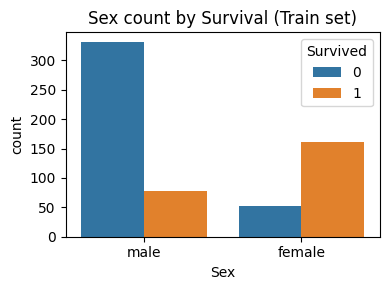

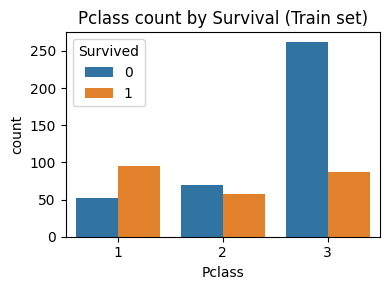

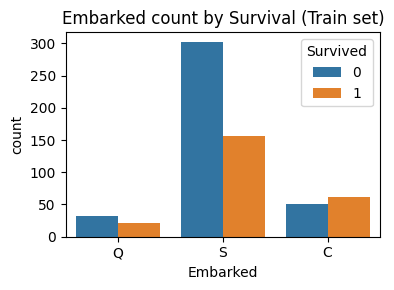

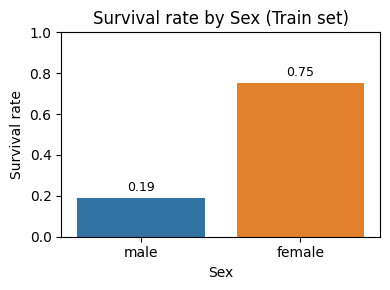

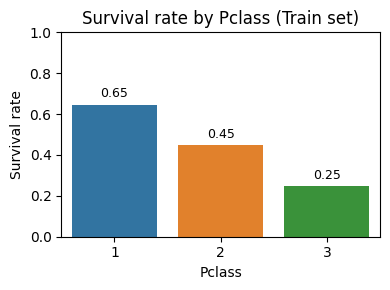

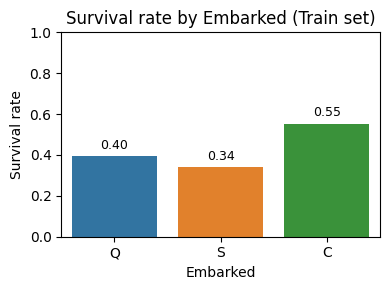

In [295]:
# ----------------------------------
# 1.6.2 Categorical Features vs Survival
# ----------------------------------

categorical_cols = ["Sex", "Pclass", "Embarked"]

# 1️⃣ Countplots (absolute counts)
for col in categorical_cols:
    plt.figure(figsize=(4, 3))
    ax = sns.countplot(
        data=df_train,
        x=col,
        hue="Survived"
    )
    plt.title(f"{col} count by Survival (Train set)")
    plt.tight_layout()
    plt.show()


# 2️⃣ Survival rate plots (with value labels)
for col in categorical_cols:
    plt.figure(figsize=(4, 3))
    ax = sns.barplot(
        data=df_train,
        x=col,
        y="Survived",
        estimator=np.mean,
        errorbar=None
    )

    plt.ylabel("Survival rate")
    plt.title(f"Survival rate by {col} (Train set)")
    plt.ylim(0, 1)

    # 🔹 Add survival rate labels on top of bars
    for p in ax.patches:
        rate = p.get_height()
        ax.annotate(
            f"{rate:.2f}",
            (p.get_x() + p.get_width() / 2., rate),
            ha="center",
            va="bottom",
            fontsize=9,
            xytext=(0, 3),
            textcoords="offset points"
        )

    plt.tight_layout()
    plt.show()



#### 1.6.3 Pairwise Correlation (Numeric + Target, Train Set)

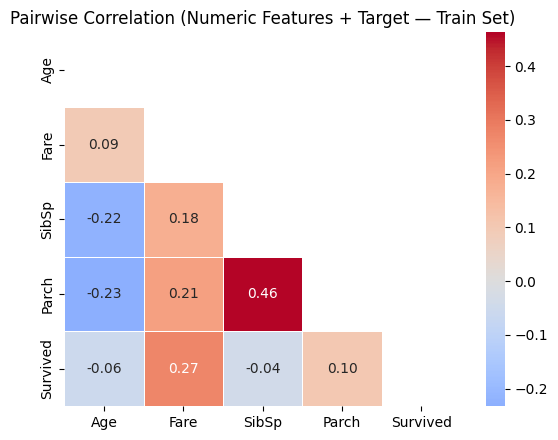

In [296]:
# ----------------------------------
# 1.6.3 Pairwise Correlation (Train Set incl. Target)
# ----------------------------------

numeric_cols = ["Age", "Fare", "SibSp", "Parch"]

df_corr = X_train[numeric_cols].copy()
df_corr["Survived"] = y_train.values

corr_matrix = df_corr.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(5.5, 4.5))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Pairwise Correlation (Numeric Features + Target — Train Set)")
plt.tight_layout()
plt.show()


### 2. Baseline Models (Rule-Based Heuristics)

#### 2.1 Baseline 1 — Sex-based Rule

Baseline 1 — Sex Rule (Train)
accuracy: 0.7897271268057785
precision: 0.7523364485981309
specificity: 0.8619791666666666
recall: 0.6736401673640168
f1: 0.7108167770419427
roc_auc: None
pr_auc: None
----------------------------------------
Baseline 1 — Sex Rule (Test)
accuracy: 0.7798507462686567
precision: 0.72
specificity: 0.8303030303030303
recall: 0.6990291262135923
f1: 0.7093596059113302
roc_auc: None
pr_auc: None
----------------------------------------


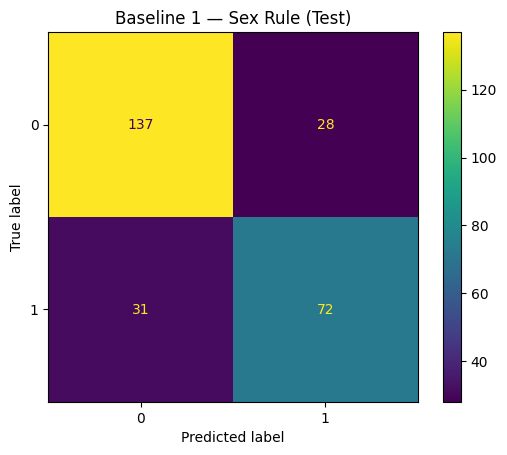

In [297]:
# ====================================
# Baseline Model 1 — Sex-based Rule
# ====================================

# Rule:
# If Sex == 'female' -> Survived = 1
# Else -> Survived = 0


# --- Baseline prediction function ---
def baseline_sex_rule(X):
    return (X["Sex"] == "female").astype(int)


# --- Train predictions ---
y_train_pred_baseline = baseline_sex_rule(X_train)

# --- Test predictions ---
y_test_pred_baseline = baseline_sex_rule(X_test)


# --- Evaluate on train ---
baseline_train_metrics = metric_report(
    y_train,
    y_train_pred_baseline,
    label="Baseline 1 — Sex Rule (Train)"
)

print("Baseline 1 — Sex Rule (Train)")
for k, v in baseline_train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# --- Evaluate on test ---
baseline_test_metrics = metric_report(
    y_test,
    y_test_pred_baseline,
    label="Baseline 1 — Sex Rule (Test)"
)

print("Baseline 1 — Sex Rule (Test)")
for k, v in baseline_test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# --- Log test performance ---
log_class_result(
    model_name="Baseline 1 — Sex Rule",
    acc=baseline_test_metrics["accuracy"],
    prec=baseline_test_metrics["precision"],
    spec=baseline_test_metrics["specificity"],
    rec=baseline_test_metrics["recall"],
    f1=baseline_test_metrics["f1"],
    roc_auc=baseline_test_metrics["roc_auc"],
    pr_auc=baseline_test_metrics["pr_auc"],
    feature_count=1
)


# --- Optional: show confusion matrix on test ---
show_confusion(
    y_test,
    y_test_pred_baseline,
    title="Baseline 1 — Sex Rule (Test)"
)


#### 2.2 Baseline 2 — Majority Class

Baseline 2 — Majority Class (Train)
accuracy: 0.6163723916532905
precision: 0.0
specificity: 1.0
recall: 0.0
f1: 0.0
roc_auc: None
pr_auc: None
----------------------------------------
Baseline 2 — Majority Class (Test)
accuracy: 0.6156716417910447
precision: 0.0
specificity: 1.0
recall: 0.0
f1: 0.0
roc_auc: None
pr_auc: None
----------------------------------------


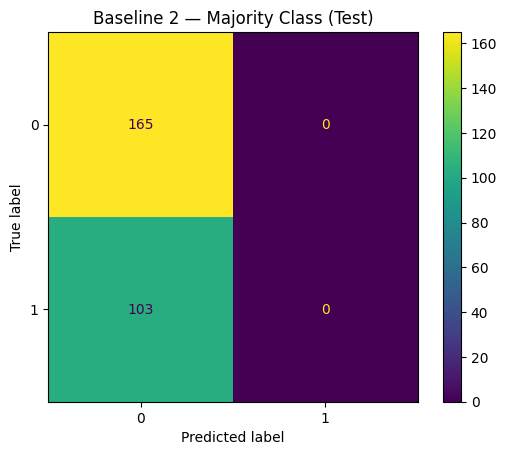

In [298]:
# ====================================
# Baseline Model 2 — Majority Class
# ====================================

# Rule:
# Predict the most frequent class in y_train for all samples


# --- Determine majority class from training data ---
majority_class = y_train.value_counts().idxmax()


# --- Train predictions ---
y_train_pred_baseline = np.full(
    shape=len(y_train),
    fill_value=majority_class
)

# --- Test predictions ---
y_test_pred_baseline = np.full(
    shape=len(y_test),
    fill_value=majority_class
)


# --- Evaluate on train ---
baseline_train_metrics = metric_report(
    y_train,
    y_train_pred_baseline,
    label="Baseline 2 — Majority Class (Train)"
)

print("Baseline 2 — Majority Class (Train)")
for k, v in baseline_train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# --- Evaluate on test ---
baseline_test_metrics = metric_report(
    y_test,
    y_test_pred_baseline,
    label="Baseline 2 — Majority Class (Test)"
)

print("Baseline 2 — Majority Class (Test)")
for k, v in baseline_test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# --- Log test performance ---
log_class_result(
    model_name="Baseline 2 — Majority Class",
    acc=baseline_test_metrics["accuracy"],
    prec=baseline_test_metrics["precision"],
    spec=baseline_test_metrics["specificity"],
    rec=baseline_test_metrics["recall"],
    f1=baseline_test_metrics["f1"],
    roc_auc=baseline_test_metrics["roc_auc"],
    pr_auc=baseline_test_metrics["pr_auc"],
    feature_count=0
)


# --- Optional: show confusion matrix on test ---
show_confusion(
    y_test,
    y_test_pred_baseline,
    title="Baseline 2 — Majority Class (Test)"
)


### 3. Logistic Regression Models

#### 3.1 — Logistic Regression (Plain / No Regularization)

Model 1a — Logistic (Plain) (Train)
accuracy: 0.8009630818619583
precision: 0.7555555555555555
specificity: 0.8567708333333334
recall: 0.7112970711297071
f1: 0.7327586206896551
roc_auc: 0.856781729428173
pr_auc: 0.8362823474165063
----------------------------------------
Model 1a — Logistic (Plain) (Test)
accuracy: 0.7798507462686567
precision: 0.7
specificity: 0.8
recall: 0.7475728155339806
f1: 0.7230046948356808
roc_auc: 0.8586348926154751
pr_auc: 0.8030338122196848
----------------------------------------


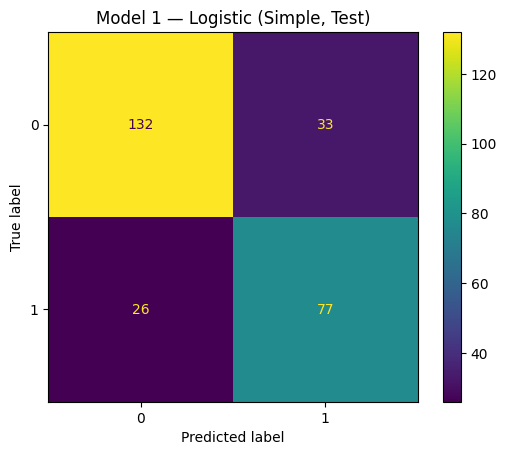

In [299]:
# ==========================================
# 3.1 Logistic Regression — Plain (No Regularization)
# ==========================================

# -------------------------------
# 1) Feature lists
# -------------------------------
numeric_features = [
    "Age",
    "Fare",
    "SibSp",
    "Parch",
]

categorical_features = [
    "Sex",
    "Pclass",
    "Embarked",
]


# -------------------------------
# 2) Preprocessor (inside pipeline)
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


# ==================================
# 3) Logistic Regression — Simple
# ==================================
pipe_logit_simple = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty= None,
        solver="lbfgs",
        max_iter=2000
    ))
])


# -------------------------------
# 4) Fit model
# -------------------------------
pipe_logit_simple.fit(X_train, y_train)


# -------------------------------
# 5) Predictions
# -------------------------------
y_train_pred = pipe_logit_simple.predict(X_train)
y_test_pred  = pipe_logit_simple.predict(X_test)

y_train_proba = pipe_logit_simple.predict_proba(X_train)[:, 1]
y_test_proba  = pipe_logit_simple.predict_proba(X_test)[:, 1]


# -------------------------------
# 6) Evaluation — Train
# -------------------------------
train_metrics = metric_report(
    y_train,
    y_train_pred,
    y_train_proba,
    label="Model 1a — Logistic (Plain) (Train)"
)

print("Model 1a — Logistic (Plain) (Train)")
for k, v in train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 7) Evaluation — Test
# -------------------------------
test_metrics = metric_report(
    y_test,
    y_test_pred,
    y_test_proba,
    label="Model 1 — Logistic (Test)"
)

print("Model 1a — Logistic (Plain) (Test)")
for k, v in test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 8) Log test performance
# -------------------------------
log_class_result(
    model_name="Model 1a — Logistic (Plain)",
    acc=test_metrics["accuracy"],
    prec=test_metrics["precision"],
    spec=test_metrics["specificity"],
    rec=test_metrics["recall"],
    f1=test_metrics["f1"],
    roc_auc=test_metrics["roc_auc"],
    pr_auc=test_metrics["pr_auc"],
    feature_count=len(numeric_features) + len(categorical_features)
)


# -------------------------------
# 9) Confusion matrix (Test)
# -------------------------------
show_confusion(
    y_test,
    y_test_pred,
    title="Model 1 — Logistic (Simple, Test)"
)


#### 3.2 Logistic Regression — L2 Regularization

Model 1b — Logistic (L2, Train)
accuracy: 0.8041733547351525
precision: 0.7695852534562212
specificity: 0.8697916666666666
recall: 0.698744769874477
f1: 0.7324561403508772
roc_auc: 0.8566509762900976
pr_auc: 0.8360315433965821
----------------------------------------
Model 1b — Logistic (L2, Test)
accuracy: 0.7835820895522388
precision: 0.7227722772277227
specificity: 0.8303030303030303
recall: 0.7087378640776699
f1: 0.7156862745098039
roc_auc: 0.8588114151220947
pr_auc: 0.8033336640552758
----------------------------------------


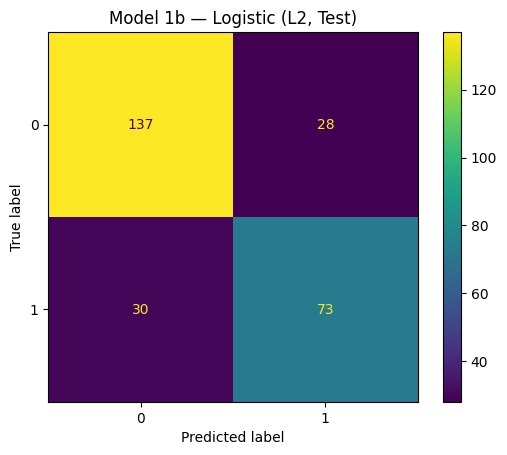

In [300]:
# ==========================================
# Model 1b — Logistic Regression (L2)
# ==========================================

# -------------------------------
# 1) Feature lists
# -------------------------------
numeric_features = [
    "Age",
    "Fare",
    "SibSp",
    "Parch",
]

categorical_features = [
    "Sex",
    "Pclass",
    "Embarked",
]


# -------------------------------
# 2) Preprocessor
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


# -------------------------------
# 3) Pipeline — Logistic L2
# -------------------------------
pipe_logit_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        C=1.0,
        max_iter=2000
    ))
])


# -------------------------------
# 4) Fit
# -------------------------------
pipe_logit_l2.fit(X_train, y_train)


# -------------------------------
# 5) Predictions
# -------------------------------
y_train_pred = pipe_logit_l2.predict(X_train)
y_test_pred  = pipe_logit_l2.predict(X_test)

y_train_proba = pipe_logit_l2.predict_proba(X_train)[:, 1]
y_test_proba  = pipe_logit_l2.predict_proba(X_test)[:, 1]


# -------------------------------
# 6) Evaluation — Train
# -------------------------------
train_metrics = metric_report(
    y_train,
    y_train_pred,
    y_train_proba,
    label="Model 1b — Logistic (L2, Train)"
)

print("Model 1b — Logistic (L2, Train)")
for k, v in train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 7) Evaluation — Test
# -------------------------------
test_metrics = metric_report(
    y_test,
    y_test_pred,
    y_test_proba,
    label="Model 1b — Logistic (L2, Test)"
)

print("Model 1b — Logistic (L2, Test)")
for k, v in test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 8) Log test performance
# -------------------------------
log_class_result(
    model_name="Model 1b — Logistic (L2)",
    acc=test_metrics["accuracy"],
    prec=test_metrics["precision"],
    spec=test_metrics["specificity"],
    rec=test_metrics["recall"],
    f1=test_metrics["f1"],
    roc_auc=test_metrics["roc_auc"],
    pr_auc=test_metrics["pr_auc"],
    feature_count=len(numeric_features) + len(categorical_features)
)


# -------------------------------
# 9) Confusion matrix — Test
# -------------------------------
show_confusion(
    y_test,
    y_test_pred,
    title="Model 1b — Logistic (L2, Test)"
)


#### 3.3 Logistic Regression — L1 Regularization

Model 1c — Logistic (L1, Train)
accuracy: 0.8025682182985554
precision: 0.7636363636363637
specificity: 0.8645833333333334
recall: 0.702928870292887
f1: 0.7320261437908496
roc_auc: 0.8562587168758715
pr_auc: 0.8365152079404151
----------------------------------------
Model 1c — Logistic (L1, Test)
accuracy: 0.7873134328358209
precision: 0.7211538461538461
specificity: 0.8242424242424242
recall: 0.7281553398058253
f1: 0.7246376811594203
roc_auc: 0.8588114151220947
pr_auc: 0.8040192323033698
----------------------------------------


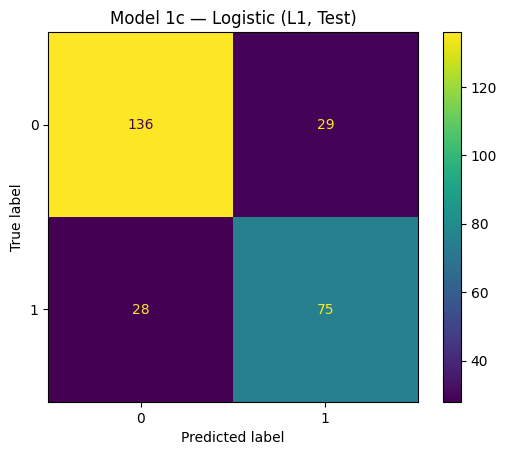

In [301]:
# ==========================================
# Model 1c — Logistic Regression (L1)
# ==========================================

# -------------------------------
# 1) Feature lists
# -------------------------------
numeric_features = [
    "Age",
    "Fare",
    "SibSp",
    "Parch",
]

categorical_features = [
    "Sex",
    "Pclass",
    "Embarked",
]


# -------------------------------
# 2) Preprocessor
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


# -------------------------------
# 3) Pipeline — Logistic L1
# -------------------------------
pipe_logit_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=1.0,
        max_iter=2000
    ))
])


# -------------------------------
# 4) Fit
# -------------------------------
pipe_logit_l1.fit(X_train, y_train)


# -------------------------------
# 5) Predictions
# -------------------------------
y_train_pred = pipe_logit_l1.predict(X_train)
y_test_pred  = pipe_logit_l1.predict(X_test)

y_train_proba = pipe_logit_l1.predict_proba(X_train)[:, 1]
y_test_proba  = pipe_logit_l1.predict_proba(X_test)[:, 1]


# -------------------------------
# 6) Evaluation — Train
# -------------------------------
train_metrics = metric_report(
    y_train,
    y_train_pred,
    y_train_proba,
    label="Model 1c — Logistic (L1, Train)"
)

print("Model 1c — Logistic (L1, Train)")
for k, v in train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 7) Evaluation — Test
# -------------------------------
test_metrics = metric_report(
    y_test,
    y_test_pred,
    y_test_proba,
    label="Model 1c — Logistic (L1, Test)"
)

print("Model 1c — Logistic (L1, Test)")
for k, v in test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 8) Log test performance
# -------------------------------
log_class_result(
    model_name="Model 1c — Logistic (L1)",
    acc=test_metrics["accuracy"],
    prec=test_metrics["precision"],
    spec=test_metrics["specificity"],
    rec=test_metrics["recall"],
    f1=test_metrics["f1"],
    roc_auc=test_metrics["roc_auc"],
    pr_auc=test_metrics["pr_auc"],
    feature_count=len(numeric_features) + len(categorical_features)
)


# -------------------------------
# 9) Confusion matrix — Test
# -------------------------------
show_confusion(
    y_test,
    y_test_pred,
    title="Model 1c — Logistic (L1, Test)"
)


### Comparison

In [302]:
# ==========================================
# Final Comparison — ROC-AUC ranking
# Baselines + Logistic (with Accuracy)
# ==========================================

df_all = pd.DataFrame(class_log)

# Keep only Baselines and Logistic models
df_filtered = df_all[
    df_all["Model"].str.startswith("Baseline")
    | df_all["Model"].str.startswith("Model 1")
].copy()


# -------------------------------
# Rank by ROC-AUC
# -------------------------------
df_ranked = (
    df_filtered[
        ["Model", "Accuracy", "ROC_AUC", "PR_AUC", "F1", "Precision", "Recall"]
    ]
    .sort_values(by="ROC_AUC", ascending=False)
    .reset_index(drop=True)
)


# -------------------------------
# Assign model family
# -------------------------------
def extract_family(model_name):
    if model_name.startswith("Baseline"):
        return "Baseline"
    if model_name.startswith("Model 1"):
        return "Logistic"
    return "Other"

df_ranked["Family"] = df_ranked["Model"].apply(extract_family)


# -------------------------------
# Soft family colors
# -------------------------------
family_colors = {
    "Baseline": "#EEEEEE",   # light gray
    "Logistic": "#E3F2FD",   # light blue
}

def highlight_family(row):
    color = family_colors.get(row["Family"], "#FFFFFF")
    return [f"background-color: {color}"] * len(row)


# -------------------------------
# Styled display
# -------------------------------
styled_df = (
    df_ranked
    .style
    .apply(highlight_family, axis=1)
    .format({
        "Accuracy": "{:.3f}",
        "ROC_AUC": "{:.3f}",
        "PR_AUC": "{:.3f}",
        "F1": "{:.3f}",
        "Precision": "{:.3f}",
        "Recall": "{:.3f}",
    })
)

display(styled_df)


,Model,Accuracy,ROC_AUC,PR_AUC,F1,Precision,Recall,Family
0,Model 1a — Logistic (Plain),0.780,0.859,0.803,0.723,0.700,0.748,Logistic
1,Model 1b — Logistic (L2),0.784,0.859,0.803,0.716,0.723,0.709,Logistic
2,Model 1c — Logistic (L1),0.787,0.859,0.804,0.725,0.721,0.728,Logistic
3,Baseline 1 — Sex Rule,0.780,nan,nan,0.709,0.720,0.699,Baseline
4,Baseline 2 — Majority Class,0.616,nan,nan,0.000,0.000,0.000,Baseline


ROC-AUC and PR-AUC are not reported for the baseline models, as these heuristics do not produce probabilistic scores or rankings.
These metrics are therefore only meaningful for the logistic regression models.

### 4.Feature Engineering

In [303]:
# ==========================================
# 4. Feature Engineering + Interactions
# ==========================================

from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np


# -------------------------------
# 1) Feature lists (raw)
# -------------------------------
numeric_linear = [
    "SibSp",
    "Parch",
]

numeric_log = [
    "Fare",
]

numeric_poly = [
    "Age",
]

categorical_features = [
    "Sex",
    "Pclass",
    "Embarked",
]

# for interactions
interaction_features = [
    "Age",      # numeric
    "Sex",      # categorical
    "Pclass",   # categorical
]


# -------------------------------
# 2) Numeric transformers
# -------------------------------

# log1p transformer (Fare)
log_transformer = Pipeline(steps=[
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])

# polynomial for Age (Age + Age^2)
poly_transformer = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

# linear numeric
linear_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])


# -------------------------------
# 3) Interaction transformer
# -------------------------------

interaction_transformer = Pipeline(steps=[
    (
        "pre",
        ColumnTransformer(
            transformers=[
                ("age", StandardScaler(), ["Age"]),
                ("sex", OneHotEncoder(drop="if_binary"), ["Sex"]),
                ("pclass", OneHotEncoder(), ["Pclass"]),
            ],
            remainder="drop"
        ),
    ),
    (
        "interactions",
        PolynomialFeatures(
            degree=2,
            interaction_only=True,
            include_bias=False
        )
    ),
])


# -------------------------------
# 4) Full preprocessor
# -------------------------------
preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num_linear", linear_transformer, numeric_linear),
        ("num_log", log_transformer, numeric_log),
        ("num_poly", poly_transformer, numeric_poly),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("interactions", interaction_transformer, interaction_features),
    ]
)


### 5. Logistic Regression Models (with Feature Engineering)
In this section, we re-train the logistic regression models using engineered features derived from exploratory analysis, including log-transformed and polynomial terms.

#### 5.1 Logistic Regression — Plain (No Regularization)

Model 5.1 — Logistic (Plain, FE, Train)
accuracy: 0.8314606741573034
precision: 0.8489583333333334
specificity: 0.9244791666666666
recall: 0.6820083682008368
f1: 0.7563805104408352
roc_auc: 0.8681790446304044
pr_auc: 0.8520863762591339
----------------------------------------
Model 5.1 — Logistic (Plain, FE, Test)
accuracy: 0.8134328358208955
precision: 0.7731958762886598
specificity: 0.8666666666666667
recall: 0.7281553398058253
f1: 0.75
roc_auc: 0.8802883200941454
pr_auc: 0.8423964165758295
----------------------------------------


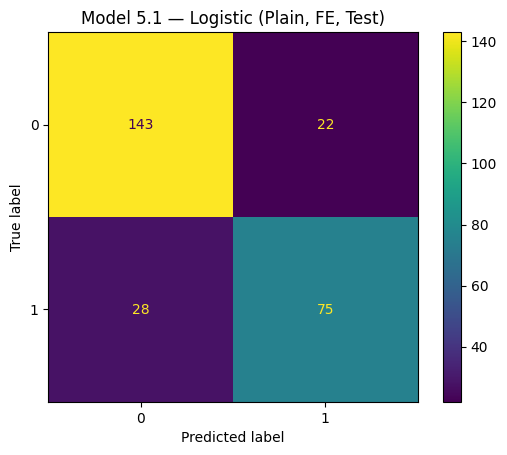

In [304]:
# ==========================================
# Model 5.1 — Logistic Regression (Plain)
# with Feature Engineering
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# -------------------------------
# 1) Pipeline = FE Preprocessor + Logistic
# -------------------------------
pipe_logit_plain_fe = Pipeline(steps=[
    ("preprocessor", preprocessor_fe),
    ("classifier", LogisticRegression(
        penalty=None,        # no regularization
        solver="lbfgs",
        max_iter=2000
    ))
])


# -------------------------------
# 2) Fit model
# -------------------------------
pipe_logit_plain_fe.fit(X_train, y_train)


# -------------------------------
# 3) Predictions
# -------------------------------
y_train_pred = pipe_logit_plain_fe.predict(X_train)
y_test_pred  = pipe_logit_plain_fe.predict(X_test)

y_train_proba = pipe_logit_plain_fe.predict_proba(X_train)[:, 1]
y_test_proba  = pipe_logit_plain_fe.predict_proba(X_test)[:, 1]


# -------------------------------
# 4) Evaluation — Train
# -------------------------------
train_metrics = metric_report(
    y_train,
    y_train_pred,
    y_train_proba,
    label="Model 5.1 — Logistic (Plain, FE, Train)"
)

print("Model 5.1 — Logistic (Plain, FE, Train)")
for k, v in train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 5) Evaluation — Test
# -------------------------------
test_metrics = metric_report(
    y_test,
    y_test_pred,
    y_test_proba,
    label="Model 5.1 — Logistic (Plain, FE, Test)"
)

print("Model 5.1 — Logistic (Plain, FE, Test)")
for k, v in test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 6) Log test performance
# -------------------------------
log_class_result(
    model_name="Model 5.1 — Logistic (Plain, FE)",
    acc=test_metrics["accuracy"],
    prec=test_metrics["precision"],
    spec=test_metrics["specificity"],
    rec=test_metrics["recall"],
    f1=test_metrics["f1"],
    roc_auc=test_metrics["roc_auc"],
    pr_auc=test_metrics["pr_auc"],
    feature_count=None  # FE expanded feature space (not raw count)
)


# -------------------------------
# 7) Confusion matrix — Test
# -------------------------------
show_confusion(
    y_test,
    y_test_pred,
    title="Model 5.1 — Logistic (Plain, FE, Test)"
)


#### 5.2 Logistic Regression — L2 Regularization

Model 5.2 — Logistic (L2, FE, Train)
accuracy: 0.8234349919743178
precision: 0.8241206030150754
specificity: 0.9088541666666666
recall: 0.6861924686192469
f1: 0.7488584474885844
roc_auc: 0.8685168235704324
pr_auc: 0.8507700189186187
----------------------------------------
Model 5.2 — Logistic (L2, FE, Test)
accuracy: 0.8097014925373134
precision: 0.76
specificity: 0.8545454545454545
recall: 0.7378640776699029
f1: 0.7487684729064039
roc_auc: 0.8786407766990292
pr_auc: 0.8451602810884878
----------------------------------------


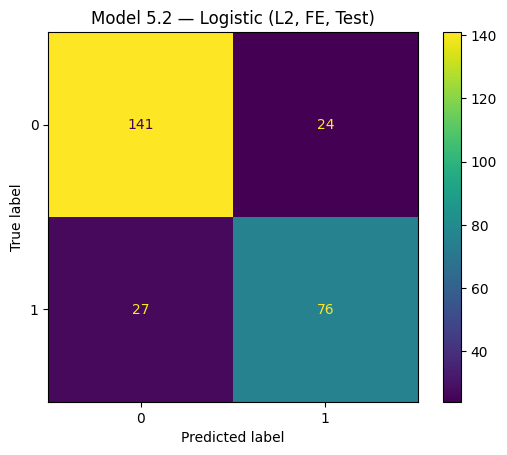

In [305]:
# ==========================================
# Model 5.2 — Logistic Regression (L2)
# with Feature Engineering
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# -------------------------------
# 1) Pipeline = FE Preprocessor + Logistic (L2)
# -------------------------------
pipe_logit_l2_fe = Pipeline(steps=[
    ("preprocessor", preprocessor_fe),
    ("classifier", LogisticRegression(
        penalty="l2",
        C=1.0,              # default strength
        solver="lbfgs",
        max_iter=2000
    ))
])


# -------------------------------
# 2) Fit model
# -------------------------------
pipe_logit_l2_fe.fit(X_train, y_train)


# -------------------------------
# 3) Predictions
# -------------------------------
y_train_pred = pipe_logit_l2_fe.predict(X_train)
y_test_pred  = pipe_logit_l2_fe.predict(X_test)

y_train_proba = pipe_logit_l2_fe.predict_proba(X_train)[:, 1]
y_test_proba  = pipe_logit_l2_fe.predict_proba(X_test)[:, 1]


# -------------------------------
# 4) Evaluation — Train
# -------------------------------
train_metrics = metric_report(
    y_train,
    y_train_pred,
    y_train_proba,
    label="Model 5.2 — Logistic (L2, FE, Train)"
)

print("Model 5.2 — Logistic (L2, FE, Train)")
for k, v in train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 5) Evaluation — Test
# -------------------------------
test_metrics = metric_report(
    y_test,
    y_test_pred,
    y_test_proba,
    label="Model 5.2 — Logistic (L2, FE, Test)"
)

print("Model 5.2 — Logistic (L2, FE, Test)")
for k, v in test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 6) Log test performance
# -------------------------------
log_class_result(
    model_name="Model 5.2 — Logistic (L2, FE)",
    acc=test_metrics["accuracy"],
    prec=test_metrics["precision"],
    spec=test_metrics["specificity"],
    rec=test_metrics["recall"],
    f1=test_metrics["f1"],
    roc_auc=test_metrics["roc_auc"],
    pr_auc=test_metrics["pr_auc"],
    feature_count=None
)


# -------------------------------
# 7) Confusion matrix — Test
# -------------------------------
show_confusion(
    y_test,
    y_test_pred,
    title="Model 5.2 — Logistic (L2, FE, Test)"
)


#### 5.3 Logistic Regression — L1 Regularization

Model 5.3 — Logistic (L1, FE, Train)
accuracy: 0.8218298555377207
precision: 0.8106796116504854
specificity: 0.8984375
recall: 0.698744769874477
f1: 0.750561797752809
roc_auc: 0.868778329846583
pr_auc: 0.8515097409158612
----------------------------------------
Model 5.3 — Logistic (L1, FE, Test)
accuracy: 0.8059701492537313
precision: 0.7575757575757576
specificity: 0.8545454545454545
recall: 0.7281553398058253
f1: 0.7425742574257427
roc_auc: 0.8762283024418946
pr_auc: 0.8459508797195187
----------------------------------------


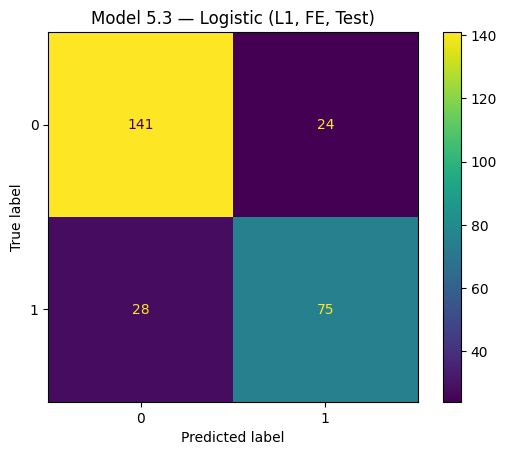

In [306]:
# ==========================================
# Model 5.3 — Logistic Regression (L1)
# with Feature Engineering
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# -------------------------------
# 1) Pipeline = FE Preprocessor + Logistic (L1)
# -------------------------------
pipe_logit_l1_fe = Pipeline(steps=[
    ("preprocessor", preprocessor_fe),
    ("classifier", LogisticRegression(
        penalty="l1",
        C=1.0,                 # default strength
        solver="liblinear",    # required for L1
        max_iter=2000
    ))
])


# -------------------------------
# 2) Fit model
# -------------------------------
pipe_logit_l1_fe.fit(X_train, y_train)


# -------------------------------
# 3) Predictions
# -------------------------------
y_train_pred = pipe_logit_l1_fe.predict(X_train)
y_test_pred  = pipe_logit_l1_fe.predict(X_test)

y_train_proba = pipe_logit_l1_fe.predict_proba(X_train)[:, 1]
y_test_proba  = pipe_logit_l1_fe.predict_proba(X_test)[:, 1]


# -------------------------------
# 4) Evaluation — Train
# -------------------------------
train_metrics = metric_report(
    y_train,
    y_train_pred,
    y_train_proba,
    label="Model 5.3 — Logistic (L1, FE, Train)"
)

print("Model 5.3 — Logistic (L1, FE, Train)")
for k, v in train_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 5) Evaluation — Test
# -------------------------------
test_metrics = metric_report(
    y_test,
    y_test_pred,
    y_test_proba,
    label="Model 5.3 — Logistic (L1, FE, Test)"
)

print("Model 5.3 — Logistic (L1, FE, Test)")
for k, v in test_metrics.items():
    if k != "model":
        print(f"{k}: {v}")
print("-" * 40)


# -------------------------------
# 6) Log test performance
# -------------------------------
log_class_result(
    model_name="Model 5.3 — Logistic (L1, FE)",
    acc=test_metrics["accuracy"],
    prec=test_metrics["precision"],
    spec=test_metrics["specificity"],
    rec=test_metrics["recall"],
    f1=test_metrics["f1"],
    roc_auc=test_metrics["roc_auc"],
    pr_auc=test_metrics["pr_auc"],
    feature_count=None
)


# -------------------------------
# 7) Confusion matrix — Test
# -------------------------------
show_confusion(
    y_test,
    y_test_pred,
    title="Model 5.3 — Logistic (L1, FE, Test)"
)


### Final Comparison — ROC-AUC ranking (All Models)

In [307]:
# ==========================================
# Final Comparison — ROC-AUC ranking
# All Models (with Accuracy)
# ==========================================

df_all = pd.DataFrame(class_log)


# -------------------------------
# 1) Select relevant columns
# -------------------------------
df_ranked = (
    df_all[
        ["Model", "Accuracy", "ROC_AUC", "PR_AUC", "F1", "Precision", "Recall"]
    ]
    .sort_values(by="ROC_AUC", ascending=False)
    .reset_index(drop=True)
)


# -------------------------------
# 2) Assign model family
# -------------------------------
def extract_family(model_name):
    if model_name.startswith("Baseline"):
        return "Baseline"
    if model_name.startswith("Model 1"):
        return "Logistic (Raw Features)"
    if model_name.startswith("Model 5"):
        return "Logistic (Feature Engineered)"
    return "Other"

df_ranked["Family"] = df_ranked["Model"].apply(extract_family)


# -------------------------------
# 3) Soft family colors
# -------------------------------
family_colors = {
    "Baseline": "#EEEEEE",                     # light gray
    "Logistic (Raw Features)": "#E3F2FD",       # light blue
    "Logistic (Feature Engineered)": "#E8F5E9", # light green
}

def highlight_family(row):
    color = family_colors.get(row["Family"], "#FFFFFF")
    return [f"background-color: {color}"] * len(row)


# -------------------------------
# 4) Styled display
# -------------------------------
styled_df = (
    df_ranked
    .style
    .apply(highlight_family, axis=1)
    .format({
        "Accuracy": "{:.3f}",
        "ROC_AUC": "{:.3f}",
        "PR_AUC": "{:.3f}",
        "F1": "{:.3f}",
        "Precision": "{:.3f}",
        "Recall": "{:.3f}",
    })
)

display(styled_df)


,Model,Accuracy,ROC_AUC,PR_AUC,F1,Precision,Recall,Family
0,"Model 5.1 — Logistic (Plain, FE)",0.813,0.880,0.842,0.750,0.773,0.728,Logistic (Feature Engineered)
1,"Model 5.2 — Logistic (L2, FE)",0.810,0.879,0.845,0.749,0.760,0.738,Logistic (Feature Engineered)
2,"Model 5.3 — Logistic (L1, FE)",0.806,0.876,0.846,0.743,0.758,0.728,Logistic (Feature Engineered)
3,Model 1a — Logistic (Plain),0.780,0.859,0.803,0.723,0.700,0.748,Logistic (Raw Features)
4,Model 1b — Logistic (L2),0.784,0.859,0.803,0.716,0.723,0.709,Logistic (Raw Features)
5,Model 1c — Logistic (L1),0.787,0.859,0.804,0.725,0.721,0.728,Logistic (Raw Features)
6,Baseline 1 — Sex Rule,0.780,nan,nan,0.709,0.720,0.699,Baseline
7,Baseline 2 — Majority Class,0.616,nan,nan,0.000,0.000,0.000,Baseline
